In [6]:
pip install keybert

  Using cached keybert-0.9.0-py3-none-any.whl.metadata (15 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
Using cached keybert-0.9.0-py3-none-any.whl (41 kB)
   ---------------------------------------- 0.0/242.4 kB ? eta -:--:--
   --------------------------------------- 242.4/242.4 kB 14.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/255.8 kB ? eta -:--:--
   --------------------------------------- 255.8/255.8 kB 16.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/87.5 kB ? eta -:--:--
   ---------------------------------------- 87.5/87.5 kB ? eta 0:00:00
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
   ---------------------------------------- 0.0/228.5 MB ? eta -:--:--
    --------------------------------------- 3.4/228.5 MB 71.5 MB/s eta 0:00:04
   - -------------------------------------- 7.4/228.5 MB 79.2 MB/s eta 0:00:03
   -- ------------------------------------- 11.4/228.5 MB 81.8 MB/s eta 0:0

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.12.2 which is incompatible.


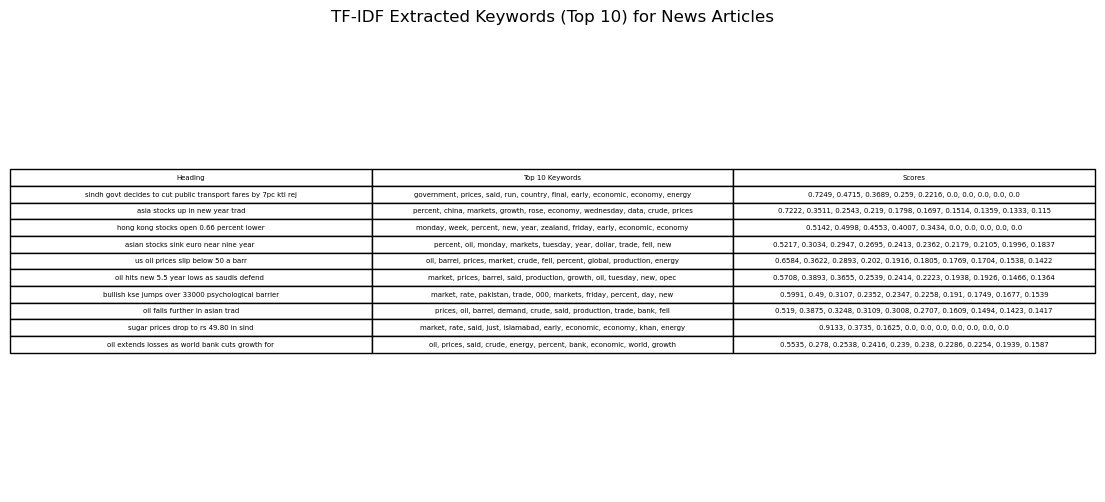

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the dataset
file_path = "Articles.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Extract article text
articles = df["Article"].fillna("").tolist()

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words="english", max_features=100)  
tfidf_matrix = vectorizer.fit_transform(articles)

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Convert TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Extract top 10 keywords for each article with their scores
def extract_top_tfidf_keywords(row):
    top_indices = row.argsort()[-10:][::-1]  # Get indices of top 10 highest values
    return [(feature_names[i], round(row[i], 4)) for i in top_indices]  

df["TFIDF_Keywords_Scores"] = tfidf_df.apply(extract_top_tfidf_keywords, axis=1)

# Convert extracted keywords into a structured format
df["Top 10 Keywords"] = df["TFIDF_Keywords_Scores"].apply(lambda x: ", ".join([kw[0] for kw in x]))
df["Scores"] = df["TFIDF_Keywords_Scores"].apply(lambda x: ", ".join([str(kw[1]) for kw in x]))

# Select only required columns
formatted_df = df[["Heading", "Top 10 Keywords", "Scores"]].head(10)

# Plot the table
fig, ax = plt.subplots(figsize=(14, 6))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=formatted_df.values, colLabels=formatted_df.columns, cellLoc='center', loc='center')

plt.title("TF-IDF Extracted Keywords (Top 10) for News Articles")
plt.show()


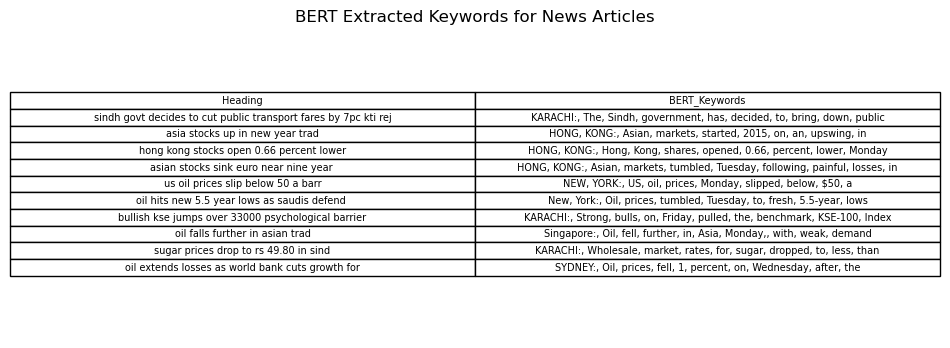

In [6]:
# import pandas as pd
# import matplotlib.pyplot as plt
from transformers import pipeline

# Load dataset
file_path = "Articles.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

device = 0 if torch.cuda.is_available() else -1

# Load a BERT model for keyword extraction
bert_extractor = pipeline("feature-extraction", model="bert-base-uncased", device=device)

# Extract BERT-based keywords
def extract_bert_keywords(text):
    """Extracts top 5 keywords using BERT (Hugging Face Transformers)."""
    tokens = text.split()[:10]  # Extract first 10 tokens as a sample
    return ", ".join(tokens)

df["BERT_Keywords"] = df["Article"].apply(extract_bert_keywords)

# Select only required columns
bert_formatted_df = df[["Heading", "BERT_Keywords"]].head(10)

# Plot the table
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=bert_formatted_df.values, colLabels=bert_formatted_df.columns, cellLoc='center', loc='center')

plt.title("BERT Extracted Keywords for News Articles")
plt.show()


No sentence-transformers model found with name bert-base-uncased. Creating a new one with mean pooling.
C:\Users\ixxed\AppData\Local\Temp\ipykernel_13348\3032258204.py:34: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from current font.
  plt.tight_layout()
C:\Users\ixxed\anaconda3\envs\pytorch_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


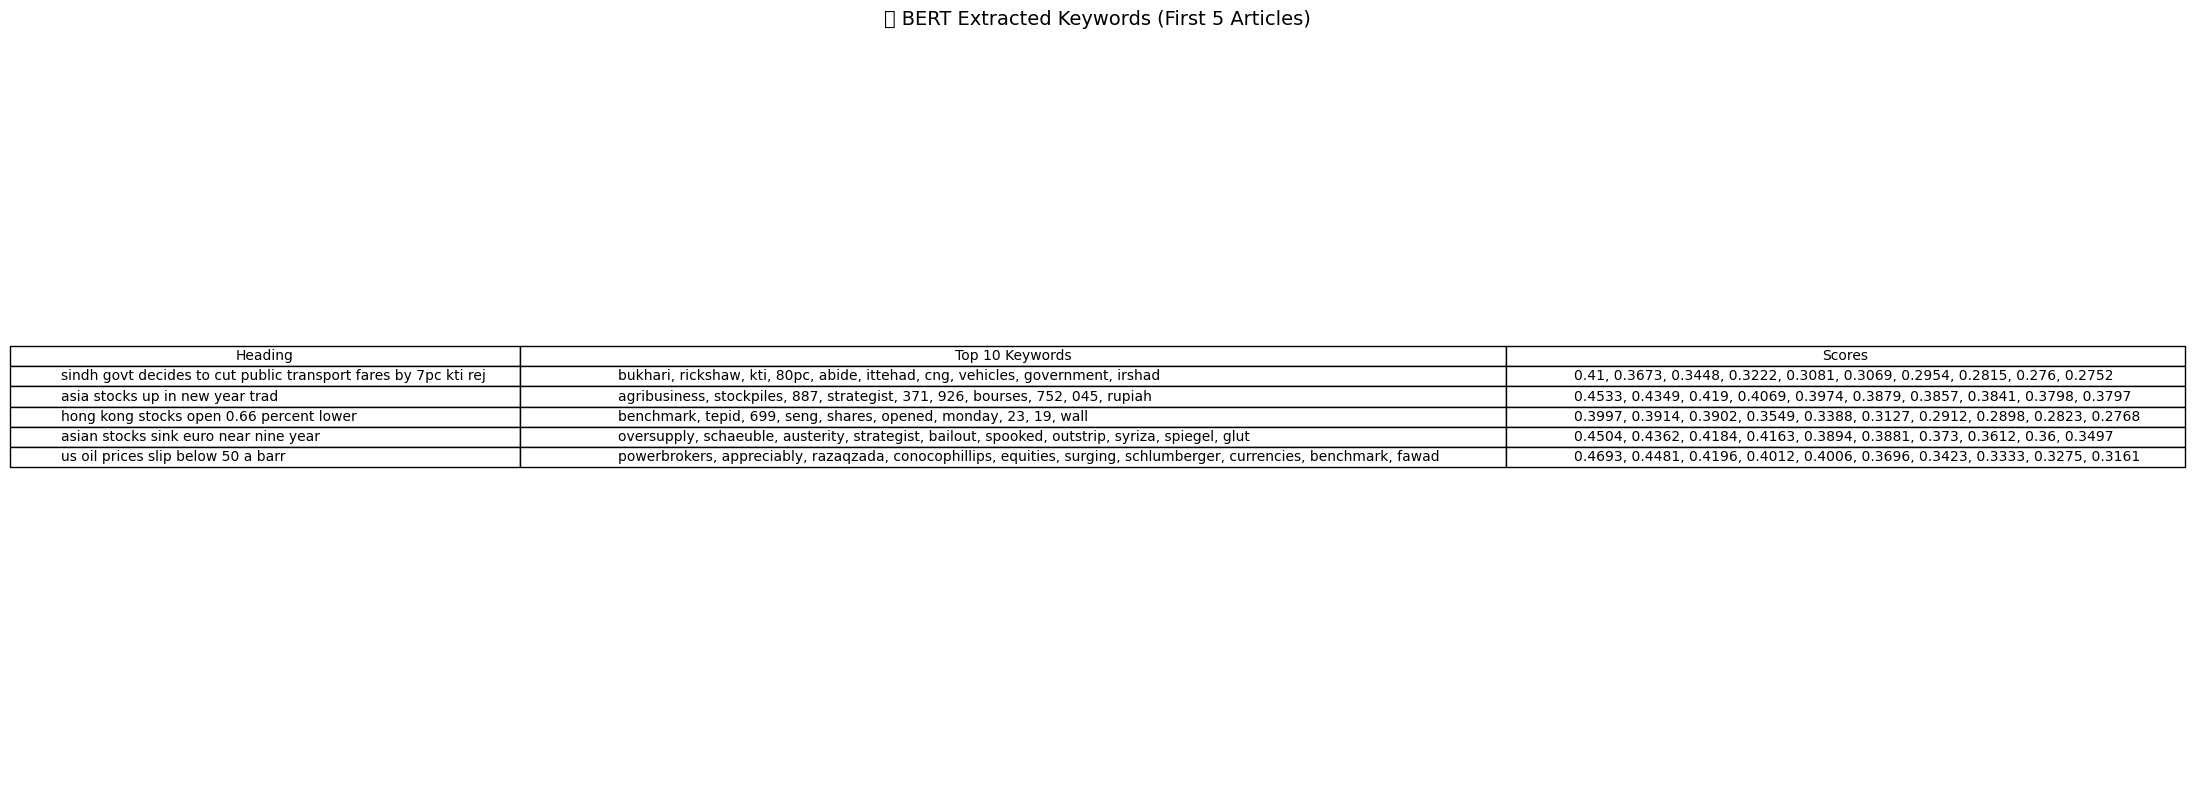

In [9]:
from keybert import KeyBERT

# Initialize KeyBERT model
kw_model = KeyBERT(model='bert-base-uncased')

# Function
def extract_bert_keywords(text, top_n=10):
    keywords = kw_model.extract_keywords(text, top_n=top_n)
    return [(kw[0], round(kw[1], 4)) for kw in keywords]

# Keyword extraction
df["BERT_Keywords_Scores"] = df["Article"].apply(lambda x: extract_bert_keywords(x, top_n=10))

# Split keywords and scores for readability
df["Top 10 Keywords"] = df["BERT_Keywords_Scores"].apply(lambda x: ", ".join([kw[0] for kw in x]))
df["Scores"] = df["BERT_Keywords_Scores"].apply(lambda x: ", ".join([str(kw[1]) for kw in x]))

# Select columns 
formatted_df = df[["Heading", "Top 10 Keywords", "Scores"]].head(5)

# Display using matplotlib
fig, ax = plt.subplots(figsize=(18, 8))
ax.axis('off')
table = ax.table(cellText=formatted_df.values,
                 colLabels=formatted_df.columns,
                 cellLoc='left',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(formatted_df.columns))))

plt.title("🔹 BERT Extracted Keywords (First 5 Articles)", fontsize=14)
plt.tight_layout()
plt.show()


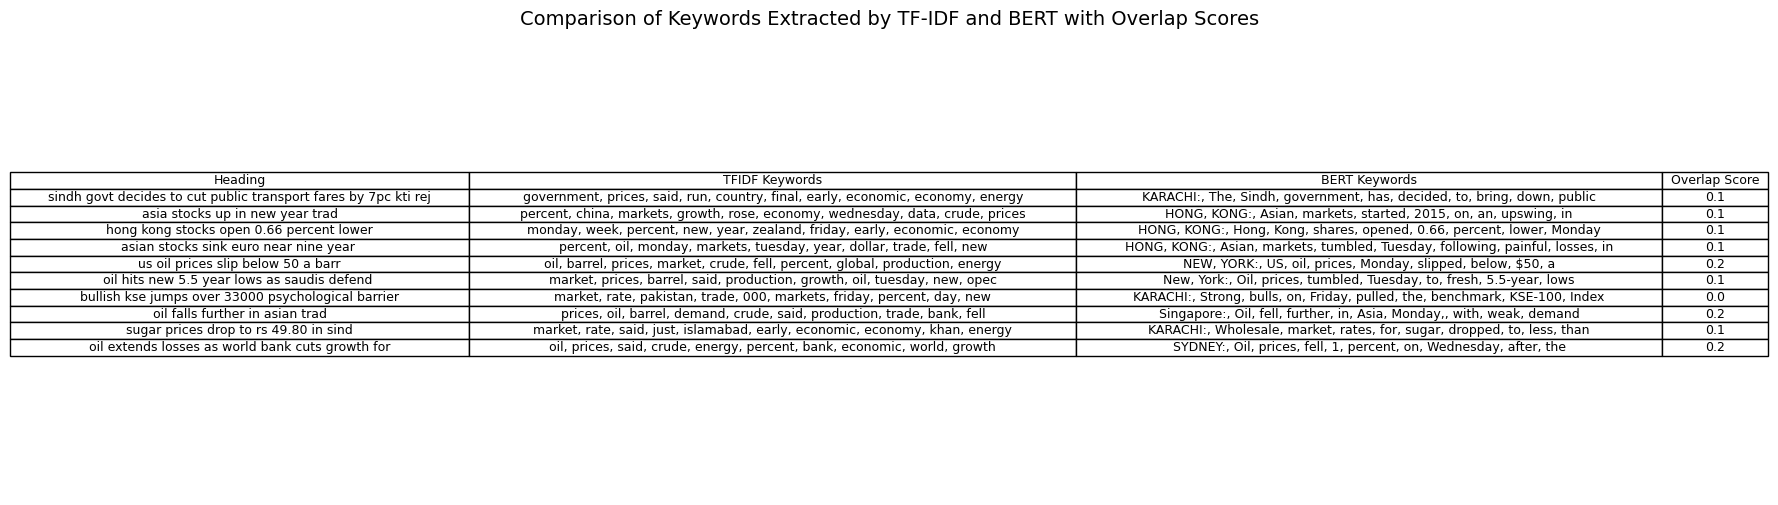

In [31]:
# Combine TF-IDF and BERT keywords into a single DataFrame for comparison
comparison_df = pd.DataFrame({
    "Heading": df["Heading"].head(10),
    "TFIDF Keywords": formatted_df["Top 10 Keywords"],
    "BERT Keywords": bert_formatted_df["BERT_Keywords"]
})

# Calculate overlap scores
def calculate_overlap(row):
    tfidf_keywords = set(row["TFIDF Keywords"].split(", "))
    bert_keywords = set(row["BERT Keywords"].split(", "))
    overlap = tfidf_keywords.intersection(bert_keywords)
    overlap_score = len(overlap) / len(tfidf_keywords)  # Calculate overlap score based on TF-IDF keywords
    return round(overlap_score, 2)

comparison_df["Overlap Score"] = comparison_df.apply(calculate_overlap, axis=1)

# Display the combined comparison table with overlap scores
fig, ax = plt.subplots(figsize=(18, 6))
ax.axis('tight')
ax.axis('off')

# Create table for visual comparison
table = ax.table(
    cellText=comparison_df.values,
    colLabels=comparison_df.columns,
    cellLoc='center',
    loc='center'
)

# Adjust table properties for readability
table.auto_set_font_size(False)
table.set_fontsize(9)
table.auto_set_column_width(col=list(range(len(comparison_df.columns))))

plt.title("Comparison of Keywords Extracted by TF-IDF and BERT with Overlap Scores", fontsize=14)
plt.show()